In [187]:
import pandas as pd
import os
import cv2
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt

from skimage import transform, exposure, restoration, feature, filters, measure
from skimage.restoration import denoise_tv_chambolle
from skimage.util import view_as_windows
from skimage import io

from cellpose import models as cellpose_models
import torch

In [200]:
def clip_intensity(img, clip_limit=None, clip_value=None):
    # Clip image intensities
    
    if clip_limit is None:
        clip_limit = np.quantile(img.flatten(), 0.99)

    if clip_value is None:
        clip_value=clip_limit     

    clipped_img = np.clip(img, 0, clip_limit)
    clipped_img[clipped_img == clip_limit] = clip_value
    return clipped_img


def clahe(img, clip_limit_clahe=None, kernel_size=None, nbins=256):
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    if clip_limit_clahe is None:
        clip_limit_clahe = .01
    
    if kernel_size is None:
        kernel_size = img.shape[0]//10 
        
    clahe = exposure.equalize_adapthist(img, clip_limit=clip_limit_clahe, kernel_size=kernel_size, nbins=nbins)
    return clahe

def denoise_image(img,weight=0.1):
    # Apply denoising using TV
    denoised_img = denoise_tv_chambolle(img,weight)
    return denoised_img

def pad_image(image):
    padded_image = np.pad(image, ((0, 4), (0, 0)), mode='constant')
    return padded_image


def scale_image(image):
    # Determine the minimum and maximum values of the image
    min_val = np.min(image)
    max_val = np.max(image)
    
    # Scale the image to the range [0, 1]
    scaled_image = (image - min_val) / (max_val - min_val)
    
    return scaled_image

def preprocess_channel(channel):
    # Clip intensity values
    channel = clip_intensity(channel)
    
    # Denoise using TV Chambolle
    channel = denoise_tv_chambolle(channel)
    
    # Scale the image
    channel = scale_image(channel).astype(np.float32)

    # channel = pad_image(channel)
    # channel[channel < 0.07] = 0
    # threshold = filters.threshold_otsu(channel)

    # binary_image = channel > threshold
    # channel[binary_image == 0] = 0

    #labeled_image, num_objects = measure.label(binary_image, background=0, return_num=True)
    
    return channel
    

def read_images_and_save(row, model, experiment_name="cancer", save_name="cancer"):
    exp_id = row['Date fixation (Exp ID)']
    teh_pat = row['Pattern utilisé (T-E-H)'].replace(',', '-')
    if teh_pat == "Flat":
        teh_pattern = teh_pat
    else:
        teh_pattern = f'TEH_{teh_pat}'
    cell_type = row['Cellules']
    directory_path = os.path.join("../database/", experiment_name, str(exp_id), teh_pattern, cell_type)
    images = []
   
    for index, filename in enumerate(os.listdir(directory_path)):
        if filename.endswith('.tif'):
            image_path = os.path.join(directory_path, filename)
            image = imageio.imread(image_path)  # Reading image using OpenCV
            intensity_values_in = np.array(image[0:2])
            intensity_values = np.zeros(intensity_values_in.shape)
            if len(image.shape) > 2: 
                for channel in range(intensity_values_in.shape[0]):
                    intensity_values[channel] = preprocess_channel(intensity_values_in[channel])
            else:
                intensity_values = preprocess_channel(intensity_values_in)
            save_directory = os.path.join("./data", save_name, "original", cell_type)
            os.makedirs(save_directory, exist_ok=True)
            save_path = os.path.join(save_directory, f"{exp_id}_{cell_type}_{teh_pattern}_{index}.tif")
            io.imsave(save_path, intensity_values)
            class_mapping = {'WT': 0, 'K32': 1, 'L380S': 2, 'R249W': 3, "Nesprin1KO": 4}  # Define mapping of cell types to class values
            #class_mapping = {'MCF10A': 0, 'BRAF': 1, 'DCIS.com': 2, 'PIK3CA H': 3, 'Rac1': 4}
            #class_mapping = {'WT': 0}
            #class_mapping = {'MCF10A': 0, }
            num_nuclei = 0
            images.append((exp_id, f"{exp_id}_{cell_type}_{teh_pattern}_{index}", save_path, class_mapping.get(cell_type, 1), num_nuclei))

    return images

In [201]:
df = pd.read_excel("../database/datasheet.xlsx", sheet_name="Fibroblast Mutations")

In [202]:
# experiment_data = df[(
#                       (df['Pattern utilisé (T-E-H)'] == '5,5,4') | 
#                       (df['Pattern utilisé (T-E-H)'] == '5,5,5.4') |
#                       (df['Pattern utilisé (T-E-H)'] == '5,8,7.6')| 
#                       (df['Pattern utilisé (T-E-H)'] == '5,6,7.6')| 
#                       (df['Pattern utilisé (T-E-H)'] == '5,5,7.6')) & (df['Marquages'].str.contains("Lamin AC")) & ((df['Cellules'] == "WT") | (df['Cellules'] == "K32")) & (df["Date fixation (Exp ID)"] != 220525)]

experiment_data = df[df['Marquages'].str.contains("Lamin AC")]

In [203]:
experiment_data

,Date fixation (Exp ID),Pattern utilisé (T-E-H),Cellules,Densité départ,Temps de culture,Marquages,Number of images
0,240215,"5,5,5.4",WT,NaN,6.5,Lamin AC (G) / Phallo (Red) / Fibro (FR),10
1,240215,"5,5,5.4",Lipo,NaN,6.5,Lamin AC (G) / Phallo (Red) / Fibro (FR),10
2,240219,"5,5,5.2",WT,NaN,5.0,Lamin AC (G) / Phallo (Red) / Tub,8
3,240219,"5,5,5.2",Lipo,NaN,5.0,Lamin AC (G) / Phallo (Red) / Tub,8
4,240221,"5,5,5.2",WT,NaN,5.0,Lamin AC (G) / Lamin B (Red) / Fibro (FR),9
5,240221,"5,5,5.2",Lipo,NaN,5.0,Lamin AC (G) / Lamin B (Red) / Fibro (FR),9


In [204]:
model_cp = cellpose_models.CellposeModel(
    gpu=True if torch.cuda.is_available() else False,
    pretrained_model="CP_myo",
)

In [205]:
experiment_name = "fibroblast"
save_name = "fibroblast_2ch"
train_images = sum(experiment_data.apply(read_images_and_save, model=model_cp, experiment_name=experiment_name, save_name=save_name,axis=1), [])
train_df = pd.DataFrame(train_images, columns=['Exp ID','original ID', 'path', 'class', "nuclei_count"])
train_df.to_csv(f'./data/{save_name}/data.csv', index=False)

## Create cropped data for experiments

In [206]:
myoblast_df = pd.read_csv(f'./data/{save_name}/data.csv')

In [235]:
def generate_sliding_windows(input_file, df, row, model):
    # Load the input image
    image = imageio.imread(input_file)
    # Define sliding window parameters
    window_size = (1024, 1024)
    stride = 510 # 20% overlap    
    output_dir = os.path.dirname(input_file.replace("original", "cropped"))
    os.makedirs(output_dir, exist_ok=True)

    
    original_filename = os.path.basename(input_file)
    filename_no_ext, ext = os.path.splitext(original_filename)

    if len(image.shape) > 2:
        
        windows = view_as_windows(image[0], window_size, stride)
    else:
        windows = view_as_windows(image, window_size, stride)

    for i in range(windows.shape[0]):
        for j in range(windows.shape[1]):
            windowed_image = np.zeros((2, window_size[0], window_size[1]))
            if len(image.shape) > 2: 
                for channel in range(image.shape[0]):
                    windows_ch = view_as_windows(image[channel], window_size, stride)
                    windowed_image[channel] = windows_ch[i, j]
            else:
                windows_ch = view_as_windows(image, window_size, stride)
                windowed_image = windows_ch[i, j]
                # Generate filename for the window
            filename = os.path.join(output_dir, f"{filename_no_ext}_window_{i}_{j}.tif")
                #pred_mask, _, _ = model.eval(window, channels=[0,0], diameter=48.11, normalize=True, net_avg=False)
                #num_nuclei = len(np.unique(pred_mask))
            io.imsave(filename, windowed_image)
            new_row = {"Exp ID": row["Exp ID"], "original ID": row["original ID"], "path": filename, "class": row["class"],}# "nuclei_count": num_nuclei}
            df = df._append(new_row, ignore_index=True)
            
    return df

def generate_sliding_windows_from_dataframe(df, model):
    res_df = pd.DataFrame()
    for index, row in df.iterrows():
        input_file = row['path']
        res_df = generate_sliding_windows(input_file, res_df, row, model)
    return res_df

In [236]:
res_df = generate_sliding_windows_from_dataframe(myoblast_df, model_cp)
res_df.to_csv(f'./data/{save_name}/data_cropped.csv', index=False)

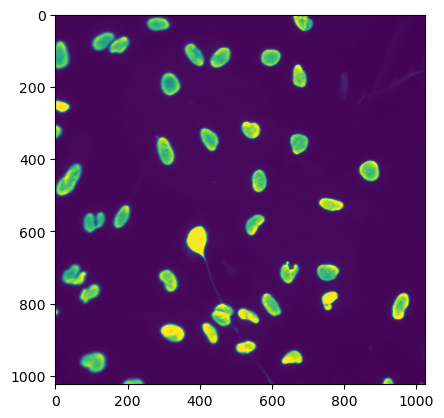

In [58]:
image = np.load("./data/myoblast_flat/cropped/K32/210929_K32_Flat_0_window_1_1.npy")
plt.imshow(image)